# Diferencia de Imagenes

## Que es la diferencia de imagenes?

La **diferencia de imagenes** es una tecnica fundamental del procesamiento digital de imagenes que consiste en comparar dos imagenes pixel a pixel para detectar cambios, movimientos o anomalias entre ellas.

### Aplicaciones principales

- **Deteccion de cambios:** Identificar modificaciones en escenas capturadas en distintos momentos (por ejemplo, imagenes satelitales para monitoreo ambiental).
- **Deteccion de movimiento (motion detection):** En sistemas de videovigilancia, detectar objetos o personas en movimiento comparando cuadros consecutivos.
- **Control de calidad industrial:** Comparar una pieza fabricada contra una referencia para encontrar defectos.
- **Imagenes medicas:** Comparar radiografias o resonancias tomadas en diferentes fechas para evaluar la evolucion de una condicion.
- **Vision por computadora:** Como paso previo en pipelines de segmentacion, tracking y reconocimiento.

### Que veremos en este notebook

Exploraremos **cinco metodos** para calcular y visualizar diferencias entre imagenes, desde la diferencia absoluta basica hasta el analisis estructural (SSIM), pasando por umbralizacion, analisis por canal de color y deteccion de contornos. Al final, compararemos los metodos con metricas cuantitativas.


---

## 1. Instalacion de dependencias e imports


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image
import os
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()

# Configuracion de matplotlib para mostrar graficos en linea
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11

print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

OpenCV version: 4.13.0
NumPy version: 2.4.2


---

## 2. Carga de imagenes

El siguiente bloque busca automaticamente archivos `img1.png`/`img1.jpg` e `img2.png`/`img2.jpg` en la carpeta del notebook. Si no los encuentra, genera un par de **imagenes sinteticas** para que el notebook sea completamente funcional sin necesidad de archivos externos.

Las imagenes sinteticas consisten en:

- **Imagen 1:** Un circulo blanco sobre fondo oscuro con un gradiente.
- **Imagen 2:** El mismo circulo desplazado hacia la derecha y un rectangulo adicional, simulando un cambio de escena.


In [ ]:
# Directorio del notebook
NOTEBOOK_DIR = Path(
    os.getenv("PROYECT_PATH", Path.cwd())
    "01_diferencia_imagenes"
)


def buscar_imagen(nombre_base: str) -> Path | None:
    """Busca una imagen con el nombre base dado en formatos png y jpg."""
    for ext in [".png", ".jpg", ".jpeg"]:
        ruta = NOTEBOOK_DIR / f"{nombre_base}{ext}"
        if ruta.exists():
            return ruta
    return None


def generar_imagenes_sinteticas(ancho: int = 400, alto: int = 300):
    """Genera dos imagenes sinteticas con diferencias visibles."""
    print("No se encontraron imagenes reales. Generando imagenes sinteticas...")

    # Imagen 1: fondo con gradiente + circulo + triangulo pequeno
    img1 = np.zeros((alto, ancho, 3), dtype=np.uint8)
    # Gradiente de fondo azul oscuro
    for y in range(alto):
        img1[y, :, 0] = int(40 * (y / alto))  # Canal B
        img1[y, :, 1] = int(30 * (y / alto))  # Canal G
        img1[y, :, 2] = int(50 * (y / alto))  # Canal R
    # Circulo blanco en el centro-izquierda
    cv2.circle(img1, (150, 150), 60, (255, 255, 255), -1)
    # Pequeno triangulo amarillo
    pts = np.array([[300, 220], [330, 270], [270, 270]], np.int32)
    cv2.fillPoly(img1, [pts], (0, 255, 255))

    # Imagen 2: misma base pero con cambios
    img2 = np.zeros((alto, ancho, 3), dtype=np.uint8)
    for y in range(alto):
        img2[y, :, 0] = int(40 * (y / alto))
        img2[y, :, 1] = int(30 * (y / alto))
        img2[y, :, 2] = int(50 * (y / alto))
    # Circulo desplazado hacia la derecha (simula movimiento)
    cv2.circle(img2, (200, 140), 60, (255, 255, 255), -1)
    # Triangulo removido, en su lugar un rectangulo verde
    cv2.rectangle(img2, (280, 200), (360, 260), (0, 200, 100), -1)
    # Nuevo elemento: pequeno circulo rojo
    cv2.circle(img2, (80, 80), 25, (0, 0, 255), -1)

    return img1, img2


# Intentar cargar imagenes reales, si no, generar sinteticas
ruta_img1 = buscar_imagen("img1")
ruta_img2 = buscar_imagen("img2")
usando_sinteticas = False

if ruta_img1 is not None and ruta_img2 is not None:
    print(f"Imagen 1 encontrada: {ruta_img1.name}")
    print(f"Imagen 2 encontrada: {ruta_img2.name}")
    img1_color = cv2.imread(str(ruta_img1))
    img2_color = cv2.imread(str(ruta_img2))
    if img1_color is None or img2_color is None:
        print("Error al leer las imagenes. Generando sinteticas como respaldo.")
        img1_color, img2_color = generar_imagenes_sinteticas()
        usando_sinteticas = True
else:
    img1_color, img2_color = generar_imagenes_sinteticas()
    usando_sinteticas = True

print(f"\nDimensiones imagen 1: {img1_color.shape}")
print(f"Dimensiones imagen 2: {img2_color.shape}")
print(f"Tipo de dato: {img1_color.dtype}")

Imagen 1 encontrada: img1.jpg
Imagen 2 encontrada: img2.jpg

Dimensiones imagen 1: (1280, 960, 3)
Dimensiones imagen 2: (1280, 960, 3)
Tipo de dato: uint8


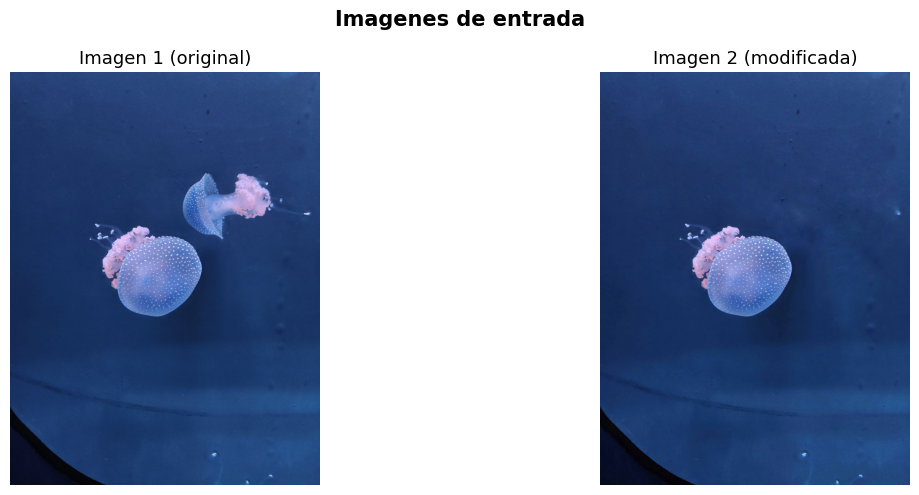

In [3]:
# Visualizar las dos imagenes lado a lado
# Nota: OpenCV carga en BGR, matplotlib espera RGB
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(cv2.cvtColor(img1_color, cv2.COLOR_BGR2RGB))
axes[0].set_title("Imagen 1 (original)")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(img2_color, cv2.COLOR_BGR2RGB))
axes[1].set_title("Imagen 2 (modificada)")
axes[1].axis("off")

plt.suptitle("Imagenes de entrada", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()

---

## 3. Preprocesamiento

Antes de calcular la diferencia entre imagenes, es necesario asegurarnos de que:

1. **Mismo tamano:** Si las imagenes tienen dimensiones diferentes, la resta pixel a pixel no es posible. Redimensionamos la segunda imagen al tamano de la primera.
2. **Escala de grises:** Para la mayoria de los metodos de diferencia, trabajar en escala de grises simplifica el analisis a un solo canal, reduciendo la complejidad computacional y eliminando variaciones de color que no son relevantes para detectar cambios de estructura.

La conversion a escala de grises se realiza con la formula ponderada:

$$Y = 0.299 \cdot R + 0.587 \cdot G + 0.114 \cdot B$$

que respeta la sensibilidad del ojo humano a cada canal de color.


Las imagenes ya tienen el mismo tamano. No es necesario redimensionar.
Dimensiones en gris - Img1: (1280, 960), Img2: (1280, 960)


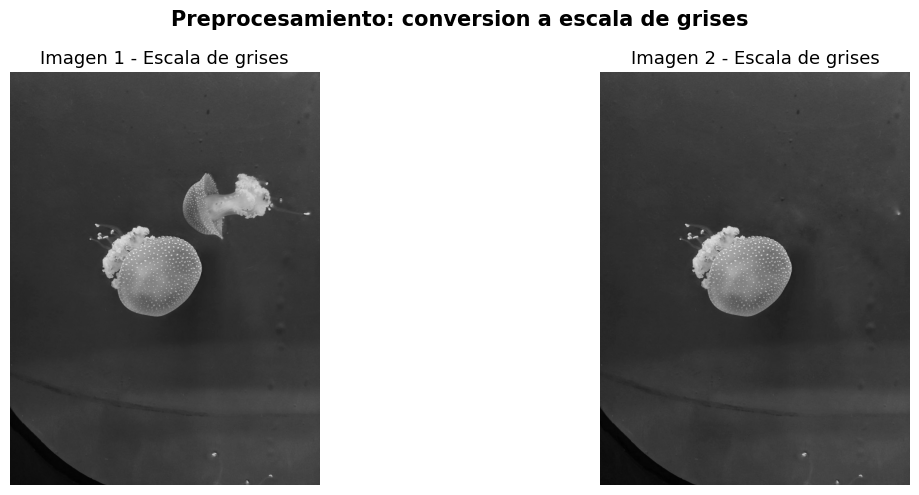

In [ ]:
# --- Paso 1: Igualar dimensiones si difieren ---
if img1_color.shape[:2] != img2_color.shape[:2]:
    alto_ref, ancho_ref = img1_color.shape[:2]
    print(
        f"Redimensionando imagen 2 de {img2_color.shape[:2]} a ({alto_ref}, {ancho_ref})")
    img2_color = cv2.resize(
        img2_color, (ancho_ref, alto_ref), interpolation=cv2.INTER_AREA)
else:
    print("Las imagenes ya tienen el mismo tamano. No es necesario redimensionar.")

# --- Paso 2: Convertir a escala de grises ---
img1_gris = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
img2_gris = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)

print(
    f"Dimensiones en gris - Img1: {img1_gris.shape}, Img2: {img2_gris.shape}")

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(img1_gris, cmap="gray")
axes[0].set_title("Imagen 1 - Escala de grises")
axes[0].axis("off")

axes[1].imshow(img2_gris, cmap="gray")
axes[1].set_title("Imagen 2 - Escala de grises")
axes[1].axis("off")

plt.suptitle("Preprocesamiento: conversion a escala de grises",
             fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()

---

## 4. Metodo 1 -- Diferencia Absoluta

La **diferencia absoluta** es el metodo mas directo para comparar dos imagenes. Para cada pixel en la posicion $(x, y)$, se calcula:

$$D(x, y) = |I_1(x, y) - I_2(x, y)|$$

donde $I_1$ e $I_2$ son las intensidades de las dos imagenes.

- Si los pixeles son identicos, el resultado es **0** (negro en la imagen de diferencia).
- Si hay un cambio grande, el resultado se acerca a **255** (blanco).

OpenCV proporciona `cv2.absdiff()` que maneja correctamente los tipos de datos sin desbordamiento (a diferencia de una resta directa con numpy donde los valores `uint8` podrian dar wrap-around).


Rango de valores en la diferencia: [False, True]
Valor promedio de diferencia: 0.47


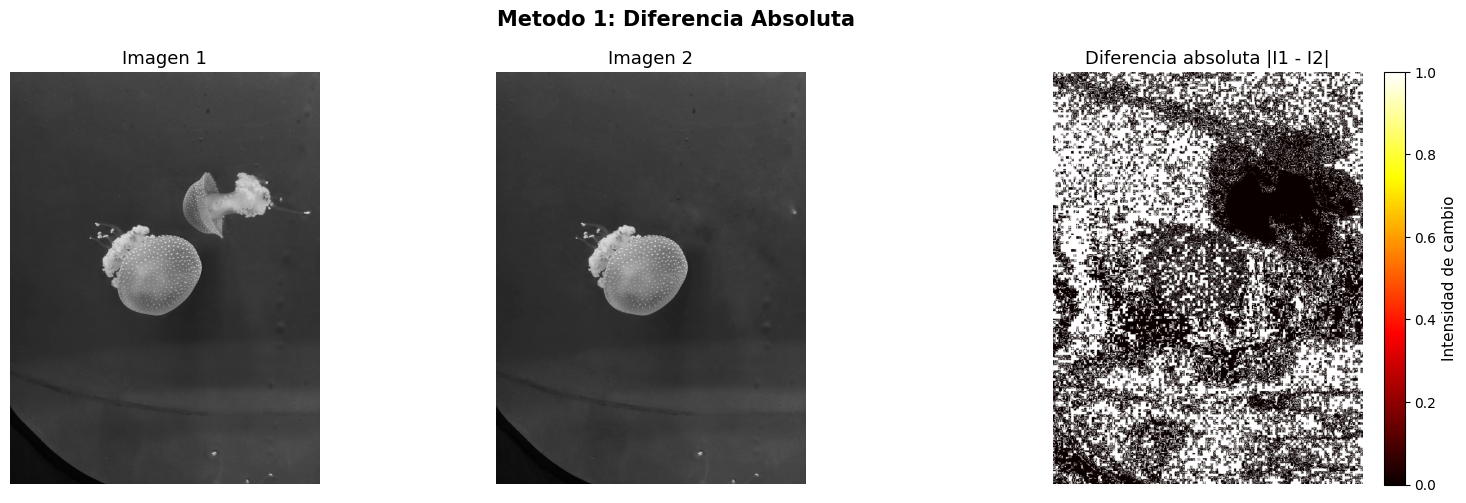

In [ ]:
# Calcular diferencia absoluta entre las imagenes en escala de grises
diff_abs = cv2.absdiff(img1_gris, img2_gris)

print(
    f"Rango de valores en la diferencia: [{diff_abs.min()}, {diff_abs.max()}]")
print(f"Valor promedio de diferencia: {diff_abs.mean():.2f}")

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(img1_gris, cmap="gray")
axes[0].set_title("Imagen 1")
axes[0].axis("off")

axes[1].imshow(img2_gris, cmap="gray")
axes[1].set_title("Imagen 2")
axes[1].axis("off")

# Usar mapa de calor para resaltar diferencias
im = axes[2].imshow(diff_abs, cmap="hot")
axes[2].set_title("Diferencia absoluta |I1 - I2|")
axes[2].axis("off")
plt.colorbar(im, ax=axes[2], fraction=0.046,
             pad=0.04, label="Intensidad de cambio")

plt.suptitle("Metodo 1: Diferencia Absoluta", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()

---

## 5. Metodo 2 -- Diferencia con umbral (Thresholding)

La diferencia absoluta nos muestra **cuanto** cambio cada pixel, pero muchas veces queremos una respuesta binaria: **cambio o no cambio**. Para eso aplicamos un **umbral** (threshold).

$$M(x, y) = \begin{cases} 255 & \text{si } D(x, y) > T \\ 0 & \text{si } D(x, y) \leq T \end{cases}$$

donde $T$ es el valor de umbral.

### Como elegir el umbral?

- **Umbral fijo:** Se selecciona manualmente un valor (por ejemplo, 30). Funciona bien cuando el nivel de ruido es conocido.
- **Umbral de Otsu:** `cv2.THRESH_OTSU` calcula automaticamente el umbral optimo que minimiza la varianza intra-clase. Es ideal cuando no conocemos el nivel de cambio esperado.

En este notebook usamos el **metodo de Otsu** para que el umbral se adapte automaticamente a los datos.


Umbral optimo calculado por Otsu: 49.0
Pixeles con cambio (Otsu): 27244 (2.22%)
Pixeles con cambio (Fijo T=30): 30935 (2.52%)


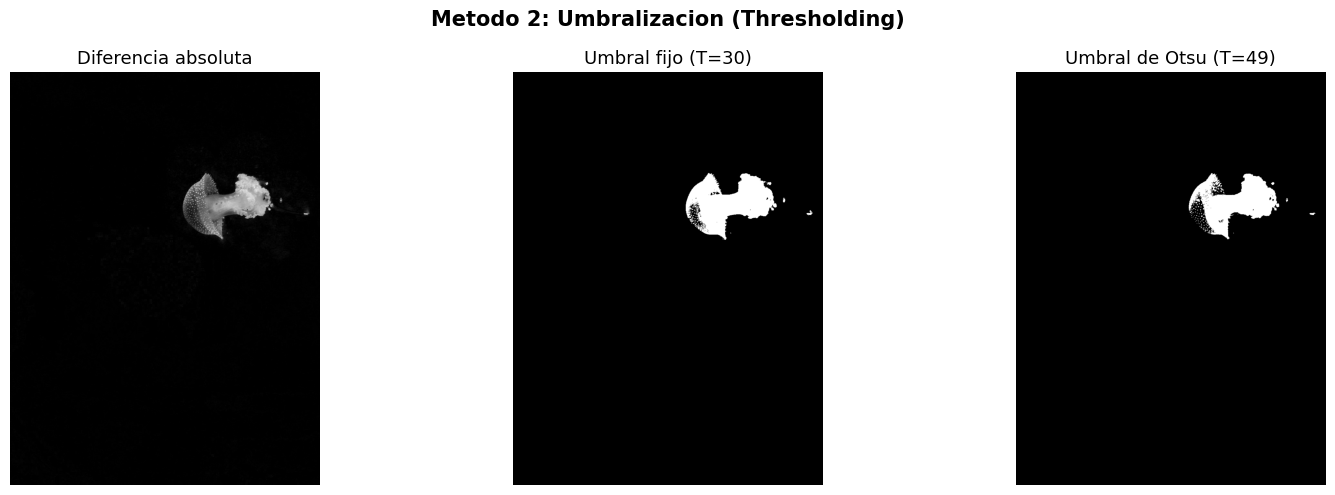

In [ ]:
# Aplicar umbral de Otsu sobre la diferencia absoluta
valor_umbral, mascara_binaria = cv2.threshold(
    diff_abs, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU
)

print(f"Umbral optimo calculado por Otsu: {valor_umbral}")

# Tambien mostrar un umbral fijo para comparar
UMBRAL_FIJO = 30
_, mascara_fija = cv2.threshold(diff_abs, UMBRAL_FIJO, 255, cv2.THRESH_BINARY)

# Contar pixeles de cambio
total_pixeles = mascara_binaria.size
pixeles_cambio_otsu = np.count_nonzero(mascara_binaria)
pixeles_cambio_fijo = np.count_nonzero(mascara_fija)

print(
    f"Pixeles con cambio (Otsu): {pixeles_cambio_otsu} ({100*pixeles_cambio_otsu/total_pixeles:.2f}%)")
print(
    f"Pixeles con cambio (Fijo T={UMBRAL_FIJO}): {pixeles_cambio_fijo} ({100*pixeles_cambio_fijo/total_pixeles:.2f}%)")

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(diff_abs, cmap="gray")
axes[0].set_title("Diferencia absoluta")
axes[0].axis("off")

axes[1].imshow(mascara_fija, cmap="gray")
axes[1].set_title(f"Umbral fijo (T={UMBRAL_FIJO})")
axes[1].axis("off")

axes[2].imshow(mascara_binaria, cmap="gray")
axes[2].set_title(f"Umbral de Otsu (T={valor_umbral:.0f})")
axes[2].axis("off")

plt.suptitle("Metodo 2: Umbralizacion (Thresholding)",
             fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()

---

## 6. Metodo 3 -- Diferencia en color (BGR/RGB)

Hasta ahora hemos trabajado en escala de grises, pero la diferencia en color nos permite ver **en que canales** se concentran los cambios. Esto es especialmente util cuando:

- Los objetos cambian de color pero no de luminosidad.
- Queremos distinguir entre cambios de iluminacion (que afectan todos los canales) y cambios de contenido (que pueden afectar canales especificos).

Calculamos `cv2.absdiff` sobre las imagenes a color completas y luego separamos el resultado por canal (B, G, R).


Promedio de diferencia por canal:
  Canal Azul (B):  4.03
  Canal Verde (G): 3.33
  Canal Rojo (R):  3.87


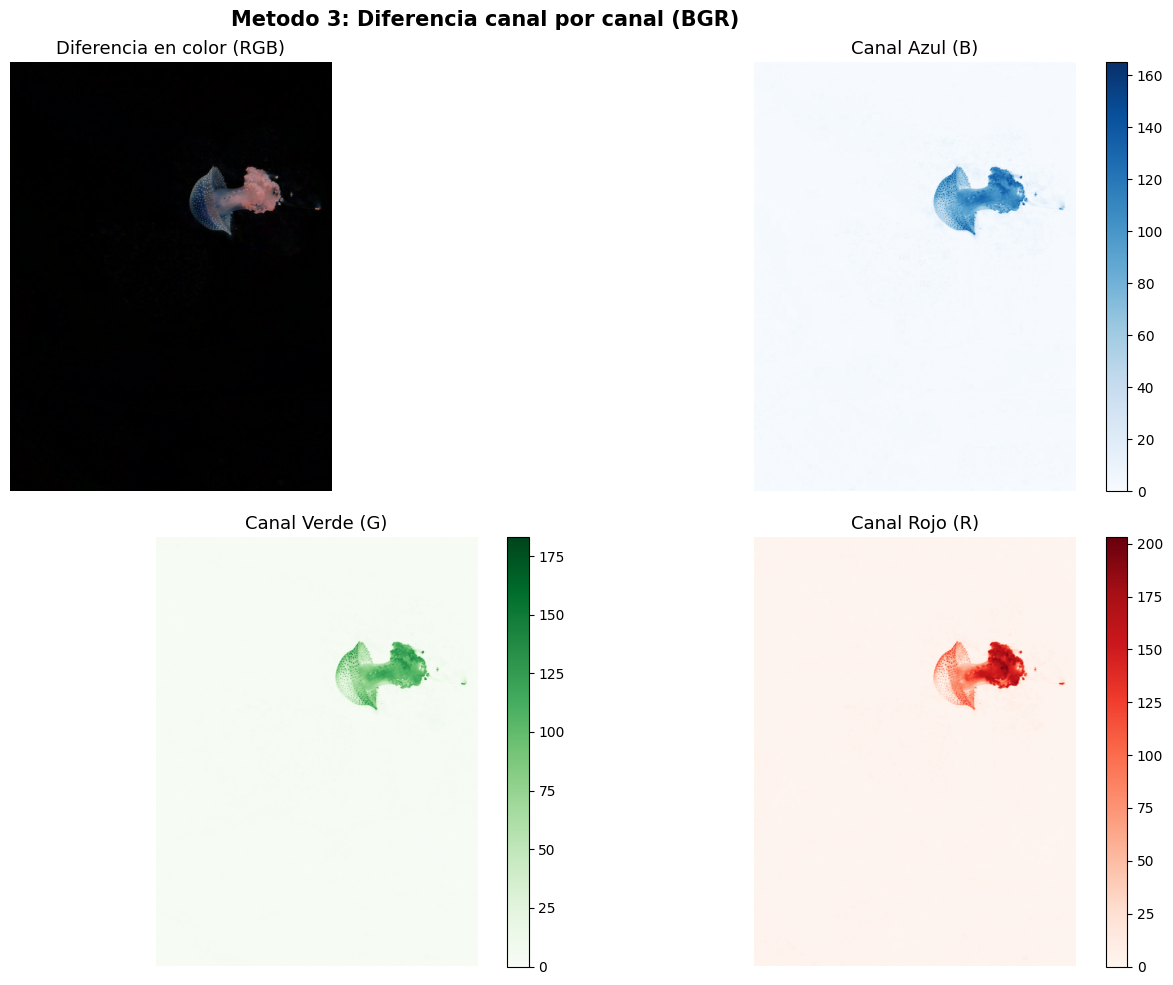

In [ ]:
# Diferencia absoluta en los tres canales de color
diff_color = cv2.absdiff(img1_color, img2_color)

# Separar por canales (OpenCV usa BGR)
diff_b, diff_g, diff_r = cv2.split(diff_color)

print(f"Promedio de diferencia por canal:")
print(f"  Canal Azul (B):  {diff_b.mean():.2f}")
print(f"  Canal Verde (G): {diff_g.mean():.2f}")
print(f"  Canal Rojo (R):  {diff_r.mean():.2f}")

# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Diferencia total en color (convertida a RGB para matplotlib)
axes[0, 0].imshow(cv2.cvtColor(diff_color, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Diferencia en color (RGB)")
axes[0, 0].axis("off")

# Canal Azul
im_b = axes[0, 1].imshow(diff_b, cmap="Blues")
axes[0, 1].set_title("Canal Azul (B)")
axes[0, 1].axis("off")
plt.colorbar(im_b, ax=axes[0, 1], fraction=0.046, pad=0.04)

# Canal Verde
im_g = axes[1, 0].imshow(diff_g, cmap="Greens")
axes[1, 0].set_title("Canal Verde (G)")
axes[1, 0].axis("off")
plt.colorbar(im_g, ax=axes[1, 0], fraction=0.046, pad=0.04)

# Canal Rojo
im_r = axes[1, 1].imshow(diff_r, cmap="Reds")
axes[1, 1].set_title("Canal Rojo (R)")
axes[1, 1].axis("off")
plt.colorbar(im_r, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.suptitle("Metodo 3: Diferencia canal por canal (BGR)",
             fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()

---

## 7. Metodo 4 -- Diferencia Estructural (SSIM)

El **Indice de Similitud Estructural (SSIM)** es una metrica perceptual que evalua la similitud entre imagenes considerando tres componentes:

1. **Luminancia:** Brillo promedio.
2. **Contraste:** Varianza de las intensidades.
3. **Estructura:** Correlacion de patrones locales.

### SSIM vs Diferencia Absoluta

| Caracteristica         | Diferencia Absoluta | SSIM                            |
| ---------------------- | ------------------- | ------------------------------- |
| Tipo de comparacion    | Pixel a pixel       | Basada en vecindarios locales   |
| Sensibilidad al ruido  | Alta                | Baja (promedia en ventanas)     |
| Correlacion perceptual | Baja                | Alta (simula percepcion humana) |
| Rango de valores       | [0, 255] por pixel  | [-1, 1] global, mapa local      |
| Costo computacional    | Bajo                | Moderado                        |

Un valor de SSIM de **1.0** indica imagenes identicas, y valores cercanos a **0** indican grandes diferencias.


Indice SSIM global: 0.9619
  (1.0 = identicas, cercano a 0 = muy diferentes)


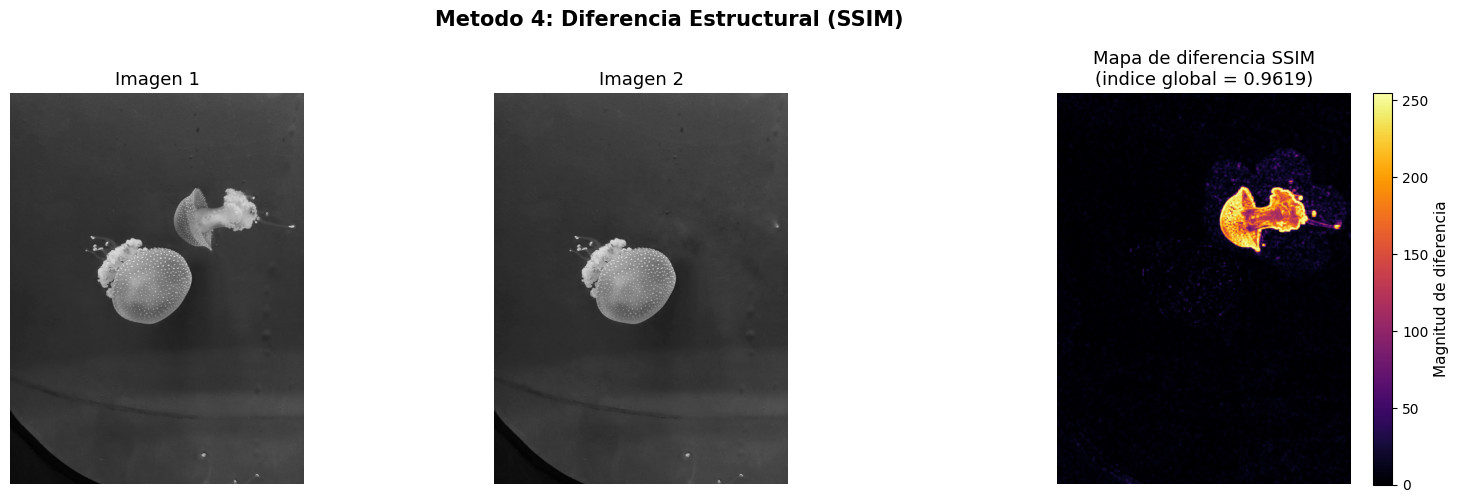

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Calcular SSIM y obtener el mapa de diferencias
# full=True retorna el mapa completo ademas del indice global
indice_ssim, mapa_ssim = ssim(img1_gris, img2_gris, full=True)

# El mapa SSIM tiene valores entre -1 y 1; convertimos a rango [0, 255]
# Invertir: areas de mayor diferencia = valores altos
mapa_ssim_vis = (1 - mapa_ssim)
mapa_ssim_uint8 = (mapa_ssim_vis * 255).clip(0, 255).astype(np.uint8)

print(f"Indice SSIM global: {indice_ssim:.4f}")
print(f"  (1.0 = identicas, cercano a 0 = muy diferentes)")

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(img1_gris, cmap="gray")
axes[0].set_title("Imagen 1")
axes[0].axis("off")

axes[1].imshow(img2_gris, cmap="gray")
axes[1].set_title("Imagen 2")
axes[1].axis("off")

im = axes[2].imshow(mapa_ssim_uint8, cmap="inferno")
axes[2].set_title(
    f"Mapa de diferencia SSIM\n(indice global = {indice_ssim:.4f})")
axes[2].axis("off")
plt.colorbar(im, ax=axes[2], fraction=0.046,
             pad=0.04, label="Magnitud de diferencia")

plt.suptitle("Metodo 4: Diferencia Estructural (SSIM)",
             fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()

---

## 8. Metodo 5 -- Contornos y regiones de cambio

A partir de la mascara binaria obtenida por umbralizacion, podemos detectar **contornos** que delimitan las regiones donde ocurrieron cambios. Esto nos permite:

1. **Localizar** exactamente donde estan los cambios con **bounding boxes** (rectangulos delimitadores).
2. **Cuantificar** el area de cada region de cambio individual.
3. **Filtrar** cambios insignificantes (ruido) descartando contornos muy pequenos.

Usamos `cv2.findContours` para extraer los bordes y `cv2.boundingRect` para obtener los rectangulos que encierran cada cambio.


In [ ]:
# Aplicar operaciones morfologicas para limpiar la mascara
# Dilatacion para unir regiones cercanas + erosion para quitar ruido
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mascara_limpia = cv2.morphologyEx(
    mascara_binaria, cv2.MORPH_CLOSE, kernel, iterations=2)
mascara_limpia = cv2.morphologyEx(
    mascara_limpia, cv2.MORPH_OPEN, kernel, iterations=1)

# Encontrar contornos
contornos, _ = cv2.findContours(
    mascara_limpia, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Filtrar contornos muy pequenos (area minima como porcentaje de la imagen)
AREA_MINIMA = 100  # pixeles cuadrados
contornos_filtrados = [
    c for c in contornos if cv2.contourArea(c) >= AREA_MINIMA]

print(f"Contornos encontrados (total): {len(contornos)}")
print(
    f"Contornos significativos (area >= {AREA_MINIMA} px): {len(contornos_filtrados)}")

# Dibujar bounding boxes sobre una copia de la imagen original
img_resultado = img1_color.copy()
area_total_cambio = 0

for i, contorno in enumerate(contornos_filtrados):
    x, y, w, h = cv2.boundingRect(contorno)
    area = cv2.contourArea(contorno)
    area_total_cambio += area

    # Dibujar rectangulo verde y etiqueta
    cv2.rectangle(img_resultado, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(
        img_resultado,
        f"#{i+1} ({area:.0f}px)",
        (x, y - 8),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.45,
        (0, 255, 0),
        1,
    )

# Calcular porcentaje de area de cambio
area_total_imagen = img1_gris.shape[0] * img1_gris.shape[1]
porcentaje_cambio = (area_total_cambio / area_total_imagen) * 100

print(
    f"\nArea total de cambio: {area_total_cambio:.0f} pixeles ({porcentaje_cambio:.2f}% de la imagen)")

Contornos encontrados (total): 4
Contornos significativos (area >= 100 px): 1

Area total de cambio: 30881 pixeles (2.51% de la imagen)


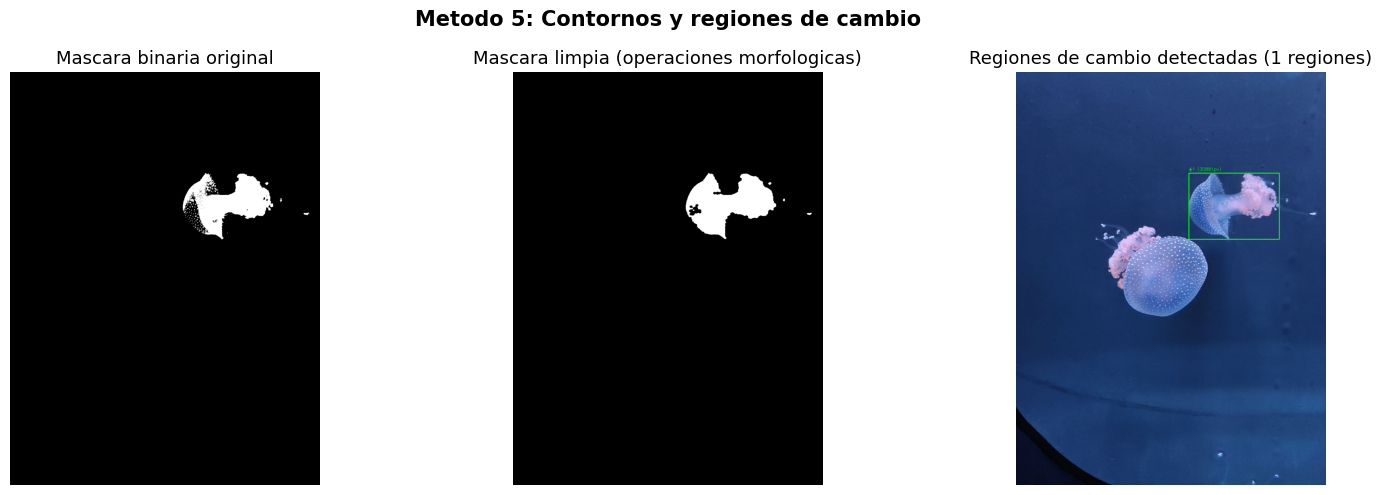

In [ ]:
# Visualizar los resultados del metodo de contornos
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(mascara_binaria, cmap="gray")
axes[0].set_title("Mascara binaria original")
axes[0].axis("off")

axes[1].imshow(mascara_limpia, cmap="gray")
axes[1].set_title("Mascara limpia (operaciones morfologicas)")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(img_resultado, cv2.COLOR_BGR2RGB))
axes[2].set_title(
    f"Regiones de cambio detectadas ({len(contornos_filtrados)} regiones)")
axes[2].axis("off")

plt.suptitle("Metodo 5: Contornos y regiones de cambio",
             fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()

---

## 9. Comparativa y metricas cuantitativas

Para evaluar objetivamente la diferencia entre las imagenes, calculamos cuatro metricas ampliamente utilizadas:

| Metrica                              | Formula                                                     | Interpretacion                                     |
| ------------------------------------ | ----------------------------------------------------------- | -------------------------------------------------- |
| **MSE** (Error Cuadratico Medio)     | $\frac{1}{N}\sum(I_1 - I_2)^2$                              | Menor = mas similares. Sensible a cambios grandes. |
| **PSNR** (Relacion Senal-Ruido Pico) | $10 \cdot \log_{10}\left(\frac{255^2}{MSE}\right)$          | Mayor = mas similares. En dB.                      |
| **SSIM** (Similitud Estructural)     | Ver seccion anterior                                        | Cercano a 1 = identicas.                           |
| **Pixeles diferentes (%)**           | $\frac{\text{pixeles con cambio}}{\text{total}} \times 100$ | Porcentaje del area que cambio.                    |


In [11]:
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

# --- Calcular metricas ---

# MSE (Error Cuadratico Medio)
mse_valor = mean_squared_error(img1_gris, img2_gris)

# PSNR (Relacion Senal-Ruido Pico)
if mse_valor > 0:
    psnr_valor = peak_signal_noise_ratio(img1_gris, img2_gris)
else:
    psnr_valor = float("inf")  # Imagenes identicas

# SSIM (ya lo calculamos antes)
ssim_valor = indice_ssim

# Porcentaje de pixeles diferentes (usando umbral de Otsu)
pixeles_dif = np.count_nonzero(mascara_binaria)
porcentaje_pixeles = (pixeles_dif / mascara_binaria.size) * 100

# --- Mostrar tabla de resultados ---
print("=" * 60)
print("      METRICAS COMPARATIVAS DE DIFERENCIA")
print("=" * 60)
print(f"{'Metrica':<35} {'Valor':>15}")
print("-" * 60)
print(f"{'MSE (Error Cuadratico Medio)':<35} {mse_valor:>15.4f}")
print(f"{'PSNR (dB)':<35} {psnr_valor:>15.2f}")
print(f"{'SSIM':<35} {ssim_valor:>15.4f}")
print(f"{'Pixeles diferentes (%)':<35} {porcentaje_pixeles:>14.2f}%")
print(f"{'Regiones de cambio detectadas':<35} {len(contornos_filtrados):>15d}")
print(f"{'Area total de cambio (px)':<35} {area_total_cambio:>15.0f}")
print("=" * 60)

      METRICAS COMPARATIVAS DE DIFERENCIA
Metrica                                       Valor
------------------------------------------------------------
MSE (Error Cuadratico Medio)               240.9951
PSNR (dB)                                     24.31
SSIM                                         0.9619
Pixeles diferentes (%)                        2.22%
Regiones de cambio detectadas                     1
Area total de cambio (px)                     30881


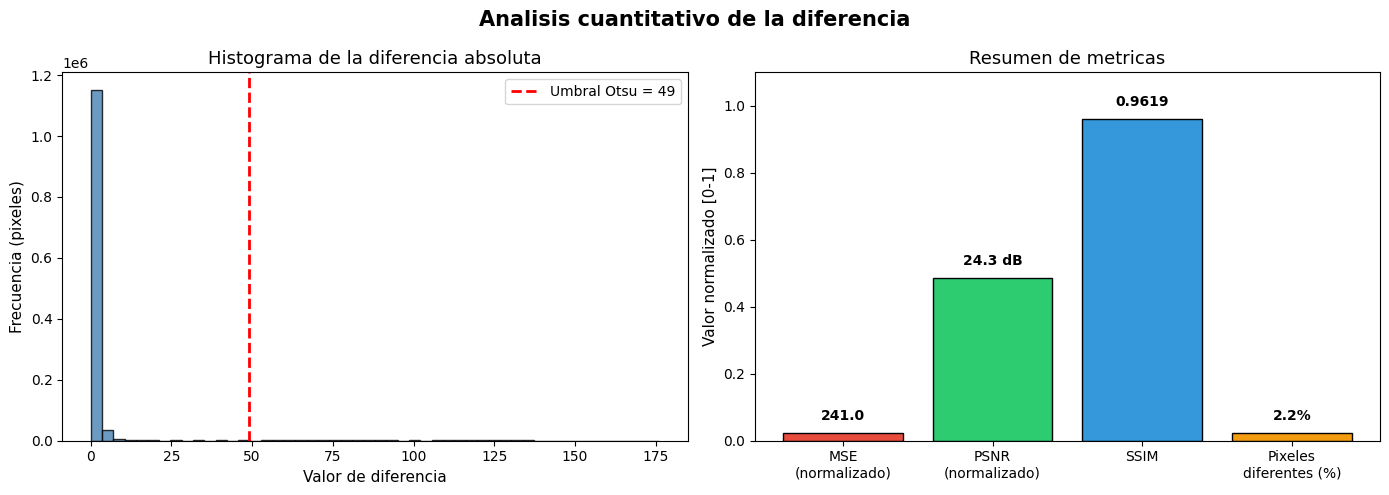

In [12]:
# Grafica comparativa: histograma de diferencia + barras de metricas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de la diferencia absoluta
axes[0].hist(diff_abs.ravel(), bins=50, color="steelblue",
             edgecolor="black", alpha=0.8)
axes[0].axvline(x=valor_umbral, color="red", linestyle="--",
                linewidth=2, label=f"Umbral Otsu = {valor_umbral:.0f}")
axes[0].set_xlabel("Valor de diferencia")
axes[0].set_ylabel("Frecuencia (pixeles)")
axes[0].set_title("Histograma de la diferencia absoluta")
axes[0].legend()

# Grafica de barras de metricas normalizadas
metricas_nombres = [
    "MSE\n(normalizado)", "PSNR\n(normalizado)", "SSIM", "Pixeles\ndiferentes (%)"]
mse_norm = min(mse_valor / 10000, 1.0)
psnr_norm = min(psnr_valor / 50, 1.0) if psnr_valor != float("inf") else 1.0
metricas_valores = [mse_norm, psnr_norm, ssim_valor, porcentaje_pixeles / 100]
colores = ["#e74c3c", "#2ecc71", "#3498db", "#f39c12"]

barras = axes[1].bar(metricas_nombres, metricas_valores,
                     color=colores, edgecolor="black")
axes[1].set_ylim(0, 1.1)
axes[1].set_ylabel("Valor normalizado [0-1]")
axes[1].set_title("Resumen de metricas")

# Etiquetas sobre las barras con valores reales
valores_reales = [f"{mse_valor:.1f}", f"{psnr_valor:.1f} dB",
                  f"{ssim_valor:.4f}", f"{porcentaje_pixeles:.1f}%"]
for barra, texto in zip(barras, valores_reales):
    axes[1].text(
        barra.get_x() + barra.get_width() / 2,
        barra.get_height() + 0.03,
        texto,
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.suptitle("Analisis cuantitativo de la diferencia",
             fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()

---

## 10. Visualizacion final: todos los metodos

Resumen visual de los cinco metodos aplicados, permitiendo una comparacion rapida de sus resultados.


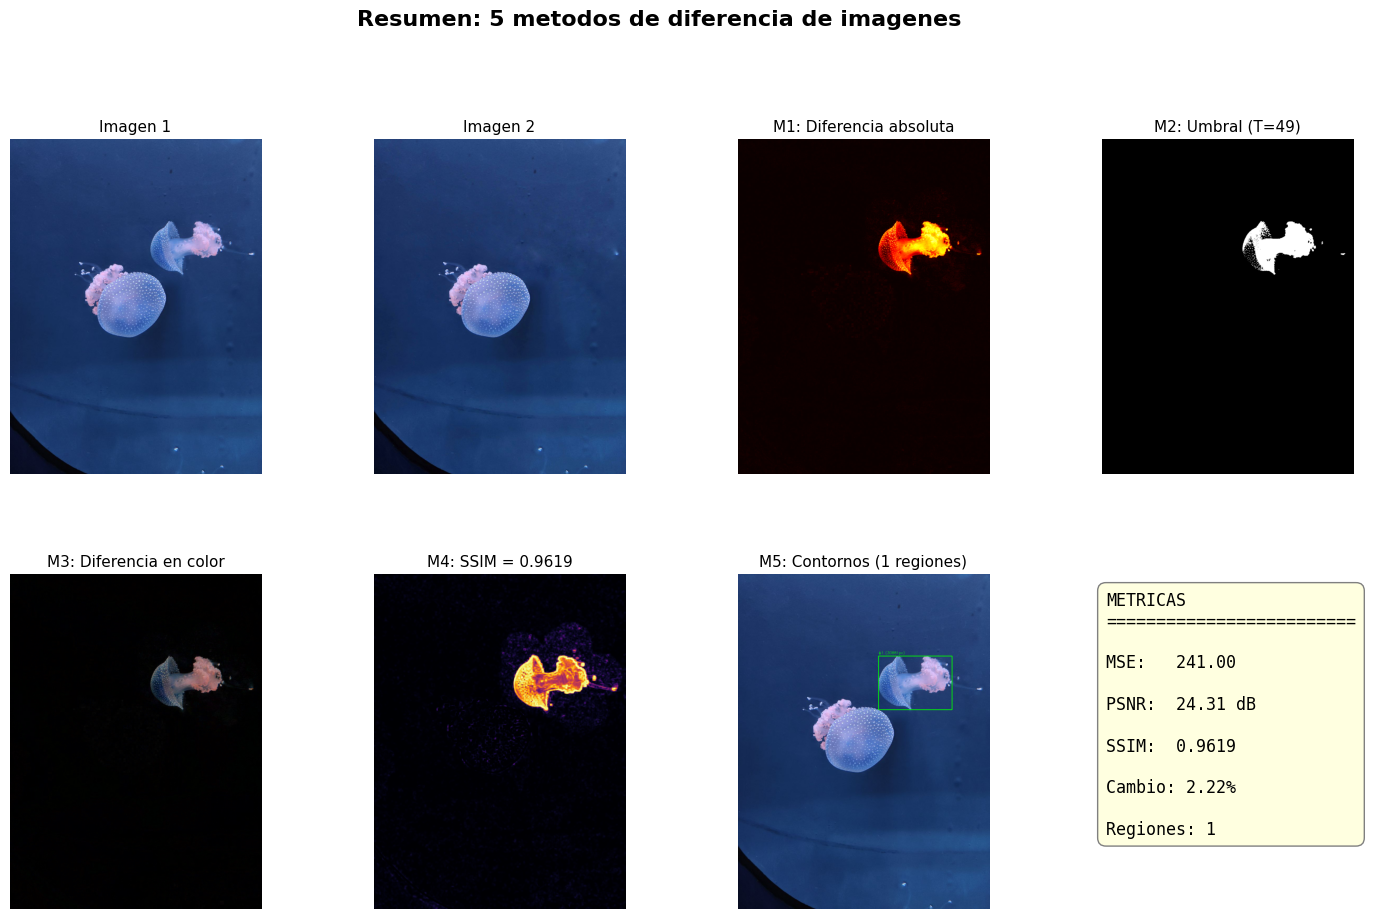

In [ ]:
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 4, figure=fig, hspace=0.3, wspace=0.2)

# Fila superior: imagenes originales + diferencia absoluta + umbral
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(cv2.cvtColor(img1_color, cv2.COLOR_BGR2RGB))
ax1.set_title("Imagen 1", fontsize=11)
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(cv2.cvtColor(img2_color, cv2.COLOR_BGR2RGB))
ax2.set_title("Imagen 2", fontsize=11)
ax2.axis("off")

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(diff_abs, cmap="hot")
ax3.set_title("M1: Diferencia absoluta", fontsize=11)
ax3.axis("off")

ax4 = fig.add_subplot(gs[0, 3])
ax4.imshow(mascara_binaria, cmap="gray")
ax4.set_title(f"M2: Umbral (T={valor_umbral:.0f})", fontsize=11)
ax4.axis("off")

# Fila inferior: color + SSIM + contornos + metricas
ax5 = fig.add_subplot(gs[1, 0])
ax5.imshow(cv2.cvtColor(diff_color, cv2.COLOR_BGR2RGB))
ax5.set_title("M3: Diferencia en color", fontsize=11)
ax5.axis("off")

ax6 = fig.add_subplot(gs[1, 1])
ax6.imshow(mapa_ssim_uint8, cmap="inferno")
ax6.set_title(f"M4: SSIM = {ssim_valor:.4f}", fontsize=11)
ax6.axis("off")

ax7 = fig.add_subplot(gs[1, 2])
ax7.imshow(cv2.cvtColor(img_resultado, cv2.COLOR_BGR2RGB))
ax7.set_title(
    f"M5: Contornos ({len(contornos_filtrados)} regiones)", fontsize=11)
ax7.axis("off")

# Panel de metricas como texto
ax8 = fig.add_subplot(gs[1, 3])
ax8.axis("off")
texto_metricas = (
    f"METRICAS\n"
    f"{'=' * 25}\n\n"
    f"MSE:   {mse_valor:.2f}\n\n"
    f"PSNR:  {psnr_valor:.2f} dB\n\n"
    f"SSIM:  {ssim_valor:.4f}\n\n"
    f"Cambio: {porcentaje_pixeles:.2f}%\n\n"
    f"Regiones: {len(contornos_filtrados)}"
)
ax8.text(
    0.1, 0.95, texto_metricas,
    transform=ax8.transAxes,
    fontsize=12,
    verticalalignment="top",
    fontfamily="monospace",
    bbox=dict(boxstyle="round,pad=0.5",
              facecolor="lightyellow", edgecolor="gray"),
)

plt.suptitle(
    "Resumen: 5 metodos de diferencia de imagenes",
    fontsize=16, fontweight="bold", y=1.01
)
plt.show()

---

## 11. Conclusiones

### Cuando usar cada metodo

| Metodo                  | Mejor caso de uso                                                      | Ventajas                                   | Limitaciones                                           |
| ----------------------- | ---------------------------------------------------------------------- | ------------------------------------------ | ------------------------------------------------------ |
| **Diferencia Absoluta** | Deteccion rapida de cambios, preprocesamiento para otros metodos       | Simple, rapido, intuitivo                  | Sensible a ruido y cambios de iluminacion              |
| **Umbralizacion**       | Generar mascaras binarias para segmentacion                            | Separa claramente cambio vs no-cambio      | La eleccion del umbral afecta mucho el resultado       |
| **Diferencia en Color** | Cuando importa saber en que canal ocurren los cambios                  | Mas informacion que escala de grises       | Tres veces mas datos que procesar                      |
| **SSIM**                | Evaluacion perceptual de calidad de imagen, comparacion con referencia | Correlaciona bien con la percepcion humana | Mayor costo computacional, requiere libreria adicional |
| **Contornos/Regiones**  | Localizar y cuantificar zonas especificas de cambio                    | Da ubicacion y area de cada cambio         | Depende de la calidad de la mascara binaria previa     |

### Recomendaciones generales

1. **Para aplicaciones en tiempo real** (videovigilancia, motion detection): usar diferencia absoluta + umbral fijo. Es lo mas rapido.
2. **Para control de calidad**: combinar SSIM (metrica global) con deteccion de contornos (localizacion precisa del defecto).
3. **Para analisis cientifico**: reportar multiples metricas (MSE, PSNR, SSIM) para dar una vision completa.
4. **Para preprocesar siempre**: aplicar operaciones morfologicas (apertura/cierre) a las mascaras binarias para eliminar ruido antes de analizar contornos.

### Nota final

La diferencia de imagenes es un paso fundamental que se integra en pipelines mas complejos de vision por computadora. Dominar estas tecnicas basicas es esencial para abordar problemas avanzados como seguimiento de objetos, reconstruccion 3D y analisis de video.
